# ANALISIS CON PYSPARK

### IMPORTAR LIBRERIAS

In [111]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, min, max, collect_list, avg, 
    row_number, desc
)

from pyspark.sql.types import NumericType
from pyspark.sql import Window
 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os
from datetime import datetime


## Crear carpeta

In [129]:
# Obtener la fecha actual en formato YYYY-MM-DD
fecha_actual = datetime.today().strftime('%Y-%m-%d')

# Obtener el directorio actual
directorio_actual = os.getcwd()

# Crear el nombre de la carpeta con la fecha
nombre_carpeta = os.path.join(directorio_actual, fecha_actual)

# Crear la carpeta si no existe
if not os.path.exists(nombre_carpeta):
    os.makedirs(nombre_carpeta)
    print(f"Carpeta creada: {nombre_carpeta}")
else:
    print(f"La carpeta ya existe: {nombre_carpeta}")


Carpeta creada: /home/lucia/Documentos/themeparks/EDA/2025-02-10


### INICIO SESIÓN CON SPARK

In [112]:
# Crear sesión de Spark
spark = SparkSession.builder.appName("EDA_ThemeParks").getOrCreate()

### CARGA DEL ARCHIVO


In [113]:

INPUT_PATH = "/home/lucia/Documentos/themeparks/ETL/themparks_database.csv"
df_spark = spark.read.csv(INPUT_PATH, header=True, inferSchema=True)

Visualización del esquema de datos

In [114]:
df_spark.printSchema()

root
 |-- land_id: integer (nullable = true)
 |-- land_name: string (nullable = true)
 |-- ride_id: integer (nullable = true)
 |-- ride_name: string (nullable = true)
 |-- is_open: boolean (nullable = true)
 |-- wait_time: integer (nullable = true)
 |-- last_update: timestamp (nullable = true)
 |-- park_name: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- local_time: timestamp (nullable = true)
 |-- local_date: date (nullable = true)
 |-- local_hour: integer (nullable = true)
 |-- local_minute: integer (nullable = true)
 |-- local_day_of_week: integer (nullable = true)
 |-- local_weekday: string (nullable = true)



Visualización de registros

In [115]:
df_spark.show()

+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|land_id|           land_name|ride_id|           ride_name|is_open|wait_time|        last_update|           park_name|     timezone|         local_time|local_date|local_hour|local_minute|local_day_of_week|local_weekday|
+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|    779|      Adventure Isle|   3079|      Camp Discovery|  false|        0|2025-01-21 14:55:23|shanghaidisneyresort|Asia/Shanghai|2025-01-21 14:55:23|2025-01-21|        21|          55|                1|      Tuesday|
|    779|      Adventure Isle|   3893|Challenge Trails ...|  false|        0|2025-01-21 14:55:23|shanghaidisneyresort|As

In [116]:
# Obtener el número total de registros en el DataFrame
num_registros = df_spark.count()

# Imprimir el número de registros
print(f"Número total de registros: {num_registros}")


Número total de registros: 129981


## FECHAS DE LOS DATOS

In [117]:
# Obtener la fecha mínima y máxima de la columna 'local_date'
fechas = df_spark.agg(
    min("local_date").alias("fecha_minima_local"),
    max("local_date").alias("fecha_maxima_local"),
    min("last_update").alias("fecha_mimina_actualización"),
    max("last_update").alias("fecha_máxima_actualización")
).collect()[0]

# Imprimir las fechas mínima y máxima
fecha_minima_local = fechas["fecha_minima_local"]
fecha_maxima_local = fechas["fecha_maxima_local"]
fecha_minima_act = fechas["fecha_mimina_actualización"]
fecha_maxima_act = fechas["fecha_máxima_actualización"]

print(f"Fecha mínima local: {fecha_minima_local}")
print(f"Fecha máxima local: {fecha_maxima_local}")
print(f"Fecha minima de actualización: {fecha_minima_act}")
print(f"Fecha máxima de actualización: {fecha_maxima_act}")


Fecha mínima local: 2025-01-21
Fecha máxima local: 2025-02-10
Fecha minima de actualización: 2025-01-21 14:55:05
Fecha máxima de actualización: 2025-02-10 10:56:43


EL ESTUDIO SE CENTRA EN DATOS RECOGIDOS ENTRE EL 21 DE ENERO DEL 2025 Y EL 10 DE FEBRERO DEL 2025.

El primer y ultimo dia no tienen registros completos vamos a eliminarlos.

In [118]:
# Filtrar los registros eliminando los que tengan la fecha de hoy y el primer día que no están completos
df_filtered = df_spark.filter(
    (col("local_date") != fecha_maxima_local) & (col("local_date") != fecha_minima_local)
)


df_filtered.show()


+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|land_id|           land_name|ride_id|           ride_name|is_open|wait_time|        last_update|           park_name|     timezone|         local_time|local_date|local_hour|local_minute|local_day_of_week|local_weekday|
+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|    779|      Adventure Isle|   3079|      Camp Discovery|  false|        0|2025-01-21 17:55:48|shanghaidisneyresort|Asia/Shanghai|2025-01-21 17:55:48|2025-01-22|         0|          55|                2|    Wednesday|
|    779|      Adventure Isle|   3893|Challenge Trails ...|  false|        0|2025-01-21 17:55:48|shanghaidisneyresort|As

Comprobamos el número de registros

In [119]:
num_registros_filter = df_filtered.count()

porcentaje_delete_register = ((num_registros-num_registros_filter)/num_registros)*100

# Imprimir el número de registros
print(f"Número total de registros actuales: {num_registros_filter}")
print(f'Porcentaje de registros eliminados: {porcentaje_delete_register:.2f}%')

Número total de registros actuales: 124258
Porcentaje de registros eliminados: 4.40%


Datos estadísticos

In [120]:
df_filtered.describe().show()

+-------+------------------+--------------+-----------------+--------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+-------------+
|summary|           land_id|     land_name|          ride_id|           ride_name|         wait_time|           park_name|           timezone|        local_hour|     local_minute| local_day_of_week|local_weekday|
+-------+------------------+--------------+-----------------+--------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+-------------+
|  count|            124258|        124258|           124258|              124258|            124258|              124258|             124258|            124258|           124258|            124258|       124258|
|   mean| 276.5777736644723|          NULL|4028.489191842779|                NULL| 9.032963672359124|                NULL|               NULL|11.834

In [121]:
# Filtrar solo las columnas numéricas
numeric_columns = [c[0] for c in df_filtered.dtypes if isinstance(df_filtered.schema[c[0]].dataType, NumericType)]

# Aplicar describe solo a las columnas numéricas
df_filtered.select(numeric_columns).describe().show()


+-------+------------------+-----------------+------------------+------------------+-----------------+------------------+
|summary|           land_id|          ride_id|         wait_time|        local_hour|     local_minute| local_day_of_week|
+-------+------------------+-----------------+------------------+------------------+-----------------+------------------+
|  count|            124258|           124258|            124258|            124258|           124258|            124258|
|   mean| 276.5777736644723|4028.489191842779| 9.032963672359124|11.834505625392328|55.44199971028022|  3.28147885850408|
| stddev|318.08553655214325|4957.005991207892|18.455396612861545| 6.678950094639143|1.834998278786227|1.9116279054941974|
|    min|                17|                1|                 0|                 0|                0|                 0|
|    max|               960|            14326|               215|                23|               58|                 6|
+-------+---------------

1. Cobertura temporal amplia:  Se registraron datos desde la medianoche hasta las 23:58.
2. Distribución de datos uniforme: Hay datos de toda la semana, con un pico entre miércoles y jueves.
3. Variabilidad en tiempos de espera: Desde 0 minutos (atracciones sin fila o cerradas) hasta 215 minutos (atracciones con altísima demanda).
4. Rangos amplios de registros: La desviación estándar indica que las colas y horarios de registro varían bastante.
5. No hay valores nulos.

### Numero de días:

In [122]:
# Contar los valores distintos de 'local_date' para saber cuántos días de datos hay
num_distinct_days = df_filtered.select("local_date").distinct().count()

# Mostrar el resultado
print(f"Número de días para el estudio: {num_distinct_days}")


Número de días para el estudio: 19


## Parques incluidos:

In [123]:
print(f'Parques incluidos en el estudio: ')
df_filtered.select('park_name').distinct().show(truncate = False)

Parques incluidos en el estudio: 
+-------------------------+
|park_name                |
+-------------------------+
|animalkingdom            |
|epcot                    |
|shanghaidisneyresort     |
|disneymagickingdom       |
|disneyhollywoodstudios   |
|disneylandparkparis      |
|waltdisneystudiosparis   |
|disneyland               |
|disneycaliforniaadventure|
+-------------------------+



## Estudio de atracciones cerradas o abiertas.

In [124]:
print(f'Número de registros de atracciones abiertas y cerradas:')
df_filtered.groupBy("is_open").count().show()


Número de registros de atracciones abiertas y cerradas:
+-------+-----+
|is_open|count|
+-------+-----+
|   true|69568|
|  false|54690|
+-------+-----+



Hay muchos registros con valores de apertura falsos que pueden deberse a que el parque estaba cerrado en ese momento o atracciones en rehabilitación. Por ello vamos a filtrar los resgistros por las atracciones que estaban abiertas para nuestro estudio.

# Separación de atracciones abiertas y cerradas

In [125]:
# Filtrar atracciones cerradas
df_closed = df_filtered.filter((col("is_open") == False) & (col("wait_time") == 0))

# Filtrar el resto de atracciones
df_open = df_filtered.filter(~((col("is_open") == False) & (col("wait_time") == 0)))

# Mostrar resultados
print("Atracciones cerradas:")
df_closed.show()



Atracciones cerradas:
+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|land_id|           land_name|ride_id|           ride_name|is_open|wait_time|        last_update|           park_name|     timezone|         local_time|local_date|local_hour|local_minute|local_day_of_week|local_weekday|
+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|    779|      Adventure Isle|   3079|      Camp Discovery|  false|        0|2025-01-21 17:55:48|shanghaidisneyresort|Asia/Shanghai|2025-01-21 17:55:48|2025-01-22|         0|          55|                2|    Wednesday|
|    779|      Adventure Isle|   3893|Challenge Trails ...|  false|        0|2025-01-21 17:55:48|s

In [126]:

print("Atracciones abiertas o con espera:")
df_open.show()

Atracciones abiertas o con espera:
+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|land_id|           land_name|ride_id|           ride_name|is_open|wait_time|        last_update|           park_name|     timezone|         local_time|local_date|local_hour|local_minute|local_day_of_week|local_weekday|
+-------+--------------------+-------+--------------------+-------+---------+-------------------+--------------------+-------------+-------------------+----------+----------+------------+-----------------+-------------+
|    780|Gardens of Imagin...|   3895|Selfie Spot with ...|   true|        5|2025-01-21 17:55:48|shanghaidisneyresort|Asia/Shanghai|2025-01-21 17:55:48|2025-01-22|         0|          55|                2|    Wednesday|
|    780|Gardens of Imagin...|   3895|Selfie Spot with ...|   true|        5|2025-01-

In [131]:
df_closed.toPandas().to_csv(os.path.join(nombre_carpeta, f"closed_rides_{fecha_actual}.csv"), index=False)
df_open.toPandas().to_csv(os.path.join(nombre_carpeta, f"opened_rides_{fecha_actual}.csv"), index=False)


/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(

Analizar las atracciones que estuvieron cerradas todo un día:

In [132]:
# Contar los registros cerrados por ride_name, local_date y park_name
df_closed_count = df_closed.groupBy("ride_name", "local_date", "park_name").agg(
    count("ride_name").alias("closed_count")
)

# Contar los registros totales por ride_name y local_date
df_total_count = df_filtered.groupBy("ride_name", "local_date", "park_name").agg(
    count("ride_name").alias("total_count")
)

# Unir los dos DataFrames para comparar el número de registros cerrados con el total
df_result = df_closed_count.join(df_total_count, on=["ride_name", "local_date", "park_name"])

# Filtrar donde todos los registros para esa atracción y día están cerrados
df_only_closed_all_day = df_result.filter(col("closed_count") == col("total_count"))

# Mostrar resultados: atracción, parque y fecha
df_only_closed_all_day.select("ride_name", "park_name", "local_date").show(truncate=False)


+------------------------------------------+--------------------+----------+
|ride_name                                 |park_name           |local_date|
+------------------------------------------+--------------------+----------+
|Slinky Dog Spin                           |shanghaidisneyresort|2025-02-09|
|Explorer Canoes                           |shanghaidisneyresort|2025-02-09|
|Kali River Rapids                         |animalkingdom       |2025-02-09|
|Selfie Spot with Mickey                   |shanghaidisneyresort|2025-02-05|
|Siren's Revenge                           |shanghaidisneyresort|2025-02-09|
|Selfie Spot with Disney Jungle Characters |shanghaidisneyresort|2025-02-07|
|Selfie Spot with Mickey                   |shanghaidisneyresort|2025-02-07|
|Selfie Spot with Princesses               |shanghaidisneyresort|2025-02-05|
|Test Track                                |epcot               |2025-01-27|
|Selfie Spot with Mickey                   |shanghaidisneyresort|2025-02-02|

In [133]:
df_only_closed_all_day.toPandas().to_csv(os.path.join(nombre_carpeta, f"closed_rides_all_day_{fecha_actual}.csv"), index=False)


Eliminamos estos registros:

In [134]:
# Obtener los registros de atracciones cerradas todo un día (ya calculado antes)
df_only_closed_all_day = df_result.filter(col("closed_count") == col("total_count")).select("ride_name", "local_date", "park_name")

# Realizar un left anti join para eliminar estos registros de df_filtered
df_filtered_clean = df_filtered.join(
    df_only_closed_all_day, 
    on=["ride_name", "local_date", "park_name"], 
    how="left_anti"
)

# Verificar que se eliminaron correctamente
df_filtered_clean.show(truncate=False)


+--------------------------------------+----------+--------------------+-------+----------------------+-------+-------+---------+-------------------+-------------+-------------------+----------+------------+-----------------+-------------+
|ride_name                             |local_date|park_name           |land_id|land_name             |ride_id|is_open|wait_time|last_update        |timezone     |local_time         |local_hour|local_minute|local_day_of_week|local_weekday|
+--------------------------------------+----------+--------------------+-------+----------------------+-------+-------+---------+-------------------+-------------+-------------------+----------+------------+-----------------+-------------+
|Camp Discovery                        |2025-01-22|shanghaidisneyresort|779    |Adventure Isle        |3079   |false  |0        |2025-01-21 17:55:48|Asia/Shanghai|2025-01-21 17:55:48|0         |55          |2                |Wednesday    |
|Challenge Trails at Camp Discovery    |

In [135]:
df_only_closed = df_closed.join(df_open, on=["ride_name"], how="left_anti")

print("Atracciones cerradas en todos los días:")
df_only_closed.select("ride_name", "park_name").distinct().show(truncate=False)


Atracciones cerradas en todos los días:
+--------------------------------------------------------------+-------------------------+
|ride_name                                                     |park_name                |
+--------------------------------------------------------------+-------------------------+
|Gran Fiesta Tour Starring The Three Caballeros                |epcot                    |
|Star Wars Launch Bay Theater                                  |disneyhollywoodstudios   |
|Kali River Rapids                                             |animalkingdom            |
|Selfie Spot with Mickey                                       |shanghaidisneyresort     |
|Astro Orbiter                                                 |disneymagickingdom       |
|The Hall of Presidents                                        |disneymagickingdom       |
|Selfie Spot with Princesses                                   |shanghaidisneyresort     |
|Selfie Spot with Disney Jungle Characters        

In [136]:
df_only_closed_distinct = df_only_closed.select("ride_name", "park_name").distinct()

df_grouped_by_park = df_only_closed_distinct.groupBy("park_name").agg(collect_list("ride_name").alias("closed_rides"))

df_grouped_by_park.show(truncate=False)


+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|park_name                |closed_rides                                                                                                                                                                   |
+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|animalkingdom            |[Kali River Rapids, Fossil Fun Games, TriceraTop Spin]                                                                                                                         |
|epcot                    |[Gran Fiesta Tour Starring The Three Caballeros, Test Track]                                                                                                 

Eliminamos esos registros:

In [137]:
# Hacer un left anti join para eliminar estas atracciones de df_filtered_clean
df_filtered_final = df_filtered_clean.join(
    df_only_closed.select("ride_name", "park_name").distinct(), 
    on=["ride_name", "park_name"], 
    how="left_anti"
)

# Verificar que se eliminaron correctamente
df_filtered_final.show(truncate=False)


+--------------------------------------+--------------------+----------+-------+----------------------+-------+-------+---------+-------------------+-------------+-------------------+----------+------------+-----------------+-------------+
|ride_name                             |park_name           |local_date|land_id|land_name             |ride_id|is_open|wait_time|last_update        |timezone     |local_time         |local_hour|local_minute|local_day_of_week|local_weekday|
+--------------------------------------+--------------------+----------+-------+----------------------+-------+-------+---------+-------------------+-------------+-------------------+----------+------------+-----------------+-------------+
|Camp Discovery                        |shanghaidisneyresort|2025-01-22|779    |Adventure Isle        |3079   |false  |0        |2025-01-21 17:55:48|Asia/Shanghai|2025-01-21 17:55:48|0         |55          |2                |Wednesday    |
|Challenge Trails at Camp Discovery    |

In [138]:
df_filtered_final.toPandas().to_csv(os.path.join(nombre_carpeta, f"clean_dataset_{fecha_actual}.csv"), index=False)

/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/lucia/.local/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(

In [139]:
df_filtered_final.describe().show()

+-------+--------------------+--------------------+------------------+--------------+-----------------+------------------+-------------------+-----------------+------------------+------------------+-------------+
|summary|           ride_name|           park_name|           land_id|     land_name|          ride_id|         wait_time|           timezone|       local_hour|      local_minute| local_day_of_week|local_weekday|
+-------+--------------------+--------------------+------------------+--------------+-----------------+------------------+-------------------+-----------------+------------------+------------------+-------------+
|  count|              111343|              111343|            111343|        111343|           111343|            111343|             111343|           111343|            111343|            111343|       111343|
|   mean|                NULL|                NULL|280.70880971412663|          NULL|4304.814950198935|10.080723529992905|               NULL|11.813

Comprobar si hay registros de horarios cerrados del parque.


In [140]:
# Contar total de atracciones por parque, fecha y hora
df_total_attractions = df_filtered_final.groupBy("park_name", "local_date", "local_hour").agg(
    count("ride_name").alias("total_rides")
)

# Contar atracciones cerradas por parque, fecha y hora
df_closed_attractions = df_filtered_final.filter((col("is_open") == False) & (col("wait_time") == 0)) \
    .groupBy("park_name", "local_date", "local_hour").agg(
    count("ride_name").alias("closed_rides")
)

# Unir ambos DataFrames
df_park_closure = df_total_attractions.join(df_closed_attractions, 
                                            on=["park_name", "local_date", "local_hour"], 
                                            how="left")

df_park_closure = df_park_closure.fillna({"closed_rides": 0})

df_park_closure.show()

# Identificar las horas donde todas las atracciones están cerradas
df_park_closure = df_park_closure.withColumn("is_park_closed", col("closed_rides") == col("total_rides"))

# Filtrar solo las horas donde el parque estuvo completamente cerrado
df_park_closed_hours = df_park_closure.filter(col("is_park_closed") == True).select("park_name", "local_date", "local_hour")

# Mostrar las horas de cierre por parque y fecha
df_park_closed_hours.show(truncate=False)


+--------------------+----------+----------+-----------+------------+
|           park_name|local_date|local_hour|total_rides|closed_rides|
+--------------------+----------+----------+-----------+------------+
|shanghaidisneyresort|2025-02-05|         9|         30|           0|
|       animalkingdom|2025-02-06|        18|         22|          11|
|shanghaidisneyresort|2025-02-04|        15|         30|           0|
|shanghaidisneyresort|2025-01-22|        15|         32|           1|
|shanghaidisneyresort|2025-01-30|         5|         32|          31|
|shanghaidisneyresort|2025-01-31|        13|         32|           0|
|shanghaidisneyresort|2025-02-01|         3|         32|          31|
|shanghaidisneyresort|2025-01-22|         1|         32|          31|
|shanghaidisneyresort|2025-02-01|         2|         32|          31|
|shanghaidisneyresort|2025-01-27|        11|         32|           0|
|shanghaidisneyresort|2025-01-28|        11|         32|           5|
|shanghaidisneyresor

No hay registros en horas de cierre del parque.

# Tiempos de espera (Atracciones abiertas)

## Por parques

In [141]:

# Calcular promedio, máximo y mínimo de wait_time por parque
df_spark_stats_open = df_filtered_final.groupBy("park_name").agg(
    avg("wait_time").alias("avg_wait_time"),
    max("wait_time").alias("max_wait_time")
)

df_spark_stats_open.show(truncate=False)



+-------------------------+------------------+-------------+
|park_name                |avg_wait_time     |max_wait_time|
+-------------------------+------------------+-------------+
|animalkingdom            |5.862800565770863 |180          |
|epcot                    |5.077697202900696 |120          |
|shanghaidisneyresort     |15.40303478904515 |165          |
|disneymagickingdom       |10.791290376198127|155          |
|disneyhollywoodstudios   |10.310011061946902|215          |
|disneylandparkparis      |11.54155337510344 |200          |
|waltdisneystudiosparis   |23.365174672489083|120          |
|disneyland               |9.308355437665783 |120          |
|disneycaliforniaadventure|8.359570921214758 |135          |
+-------------------------+------------------+-------------+



In [146]:

# Parque con menor tiempo medio de espera
park_lowest_avg = df_spark_stats_open.orderBy(col("avg_wait_time").asc()).limit(1)
# Parque con mayor tiempo medio de espera
park_highest_avg = df_spark_stats_open.orderBy(col("avg_wait_time").desc()).limit(1)

# Parque con mayor tiempo de espera registrado
park_max_wait = df_spark_stats_open.orderBy(col("max_wait_time").desc()).limit(1)

# Mostrar resultados
print("Parque con menor tiempo medio de espera:")
park_lowest_avg.show(truncate=False)

print("Parque con mayor tiempo medio de espera:")
park_highest_avg.show(truncate=False)


print("Parque con mayor tiempo de espera registrado:")
park_max_wait.show(truncate=False)


Parque con menor tiempo medio de espera:
+---------+-----------------+-------------+
|park_name|avg_wait_time    |max_wait_time|
+---------+-----------------+-------------+
|epcot    |5.077697202900696|120          |
+---------+-----------------+-------------+

Parque con mayor tiempo medio de espera:
+----------------------+------------------+-------------+
|park_name             |avg_wait_time     |max_wait_time|
+----------------------+------------------+-------------+
|waltdisneystudiosparis|23.365174672489083|120          |
+----------------------+------------------+-------------+

Parque con mayor tiempo de espera registrado:
+----------------------+------------------+-------------+
|park_name             |avg_wait_time     |max_wait_time|
+----------------------+------------------+-------------+
|disneyhollywoodstudios|10.310011061946902|215          |
+----------------------+------------------+-------------+



Dia de la semana con mayor tiempo medio de espera por parque:

In [143]:
df_spark_stats_days_avg = df_filtered_final.groupBy("park_name", "local_weekday").agg(
    avg("wait_time").alias("avg_wait_time"),
    max("wait_time").alias("max_wait_time")
)

df_max_avg_wait_per_day = df_spark_stats_days_avg.withColumn(
    "max_avg_wait_day", 
    row_number().over(Window.partitionBy("park_name").orderBy(col("avg_wait_time").desc()))
).filter(col("max_avg_wait_day") == 1).drop("max_avg_wait_day")

df_max_wait_per_day = df_spark_stats_days_avg.withColumn(
    "max_wait_day", 
    row_number().over(Window.partitionBy("park_name").orderBy(col("max_wait_time").desc()))
).filter(col("max_wait_day") == 1).drop("max_wait_day")

print("Dia de la semana con más media de tiempos de espera por parque:")
df_max_avg_wait_per_day.show(truncate=False)


Dia de la semana con más media de tiempos de espera por parque:
+-------------------------+-------------+------------------+-------------+
|park_name                |local_weekday|avg_wait_time     |max_wait_time|
+-------------------------+-------------+------------------+-------------+
|animalkingdom            |Saturday     |7.641025641025641 |175          |
|disneycaliforniaadventure|Tuesday      |9.810035842293907 |100          |
|disneyhollywoodstudios   |Saturday     |11.27951388888889 |125          |
|disneyland               |Monday       |11.224806201550388|120          |
|disneylandparkparis      |Saturday     |14.613670133729569|130          |
|disneymagickingdom       |Friday       |13.202965054712319|155          |
|epcot                    |Monday       |5.621527777777778 |95           |
|shanghaidisneyresort     |Tuesday      |22.507163323782233|135          |
|waltdisneystudiosparis   |Saturday     |24.871794871794872|120          |
+-------------------------+---------

In [148]:
print("Dia de la semana con el tiempo de espera máximo por parque:")
df_max_wait_per_day.orderBy('max_wait_time').show(truncate=False)

Dia de la semana con el tiempo de espera máximo por parque:
+-------------------------+-------------+------------------+-------------+
|park_name                |local_weekday|avg_wait_time     |max_wait_time|
+-------------------------+-------------+------------------+-------------+
|disneyland               |Monday       |11.224806201550388|120          |
|epcot                    |Sunday       |4.962962962962963 |120          |
|waltdisneystudiosparis   |Tuesday      |22.61744966442953 |120          |
|disneycaliforniaadventure|Thursday     |7.918981481481482 |135          |
|disneymagickingdom       |Friday       |13.202965054712319|155          |
|shanghaidisneyresort     |Sunday       |14.048076923076923|165          |
|animalkingdom            |Thursday     |4.90530303030303  |180          |
|disneylandparkparis      |Wednesday    |9.896131805157593 |200          |
|disneyhollywoodstudios   |Sunday       |11.078703703703704|215          |
+-------------------------+-------------

# POR ATRACCIONES

In [149]:

df_spark_stats_rides = df_filtered_final.groupBy("park_name","ride_name").agg(
    avg("wait_time").alias("avg_wait_time"),
    max("wait_time").alias("max_wait_time"),
)

df_spark_stats_rides.orderBy("avg_wait_time", ascending=False).show(truncate=False)

+-------------------------+--------------------------------------------------+------------------+-------------+
|park_name                |ride_name                                         |avg_wait_time     |max_wait_time|
+-------------------------+--------------------------------------------------+------------------+-------------+
|waltdisneystudiosparis   |Crush's Coaster                                   |66.68981481481481 |120          |
|shanghaidisneyresort     |Seven Dwarfs Mine Train                           |56.86915887850467 |165          |
|shanghaidisneyresort     |Soaring Over the Horizon                          |55.981308411214954|165          |
|waltdisneystudiosparis   |The Twilight Zone Tower of Terror                 |51.75925925925926 |120          |
|shanghaidisneyresort     |Zootopia: Hot Pursuit                             |50.677570093457945|150          |
|waltdisneystudiosparis   |Crush's Coaster Single Rider                      |46.226851851851855|90     

In [150]:
df_spark_stats_rides.orderBy("max_wait_time", ascending=False).show(truncate=False)

+-------------------------+--------------------------------------------------+------------------+-------------+
|park_name                |ride_name                                         |avg_wait_time     |max_wait_time|
+-------------------------+--------------------------------------------------+------------------+-------------+
|disneyhollywoodstudios   |The Twilight Zone Tower of Terror™                |25.194690265486727|215          |
|disneylandparkparis      |Princess Pavilion                                 |43.41269841269841 |200          |
|animalkingdom            |Avatar Flight of Passage                          |40.2212389380531  |180          |
|disneyhollywoodstudios   |Star Wars: Rise of the Resistance                 |31.559734513274336|180          |
|shanghaidisneyresort     |Seven Dwarfs Mine Train                           |56.86915887850467 |165          |
|shanghaidisneyresort     |Soaring Over the Horizon                          |55.981308411214954|165    

In [151]:
# Atracción con mayor tiempo medio de espera
ride_highest_avg = df_spark_stats_rides.orderBy(col("avg_wait_time").desc()).limit(1)

# Atracción con mayor tiempo de espera registrado
ride_max_wait = df_spark_stats_rides.orderBy(col("max_wait_time").desc()).limit(1)

print("Atracción con mayor tiempo medio de espera:")
ride_highest_avg.show(truncate=False)

print("Atracción con mayor tiempo de espera registrado:")
ride_max_wait.show(truncate=False)


Atracción con mayor tiempo medio de espera:
+----------------------+---------------+-----------------+-------------+
|park_name             |ride_name      |avg_wait_time    |max_wait_time|
+----------------------+---------------+-----------------+-------------+
|waltdisneystudiosparis|Crush's Coaster|66.68981481481481|120          |
+----------------------+---------------+-----------------+-------------+

Atracción con mayor tiempo de espera registrado:
+----------------------+----------------------------------+------------------+-------------+
|park_name             |ride_name                         |avg_wait_time     |max_wait_time|
+----------------------+----------------------------------+------------------+-------------+
|disneyhollywoodstudios|The Twilight Zone Tower of Terror™|25.194690265486727|215          |
+----------------------+----------------------------------+------------------+-------------+



Comprobamos que día de la semana tienen la media más alta de tiempos de espera:

In [152]:
df_spark_stats_days_avg = df_filtered_final.groupBy("park_name", "ride_name", "local_weekday").agg(
    avg("wait_time").alias("avg_wait_time")
)

# Para cada parque y atracción, encontrar el día de la semana con la mayor media de espera
df_max_avg_wait_per_day = df_spark_stats_days_avg.withColumn(
    "max_avg_wait_day", 
    row_number().over(Window.partitionBy("park_name", "ride_name").orderBy(col("avg_wait_time").desc()))
).filter(col("max_avg_wait_day") == 1).drop("max_avg_wait_day")

# Mostrar resultados
df_max_avg_wait_per_day.orderBy("avg_wait_time", ascending=False).show(truncate=False)


+-------------------------+--------------------------------------------------+-------------+------------------+
|park_name                |ride_name                                         |local_weekday|avg_wait_time     |
+-------------------------+--------------------------------------------------+-------------+------------------+
|shanghaidisneyresort     |Soaring Over the Horizon                          |Tuesday      |89.11111111111111 |
|shanghaidisneyresort     |Seven Dwarfs Mine Train                           |Tuesday      |86.33333333333333 |
|shanghaidisneyresort     |Zootopia: Hot Pursuit                             |Tuesday      |83.55555555555556 |
|waltdisneystudiosparis   |Crush's Coaster                                   |Tuesday      |71.38888888888889 |
|waltdisneystudiosparis   |The Twilight Zone Tower of Terror                 |Thursday     |60.45454545454545 |
|disneymagickingdom       |TRON Lightcycle / Run                             |Friday       |56.971830985

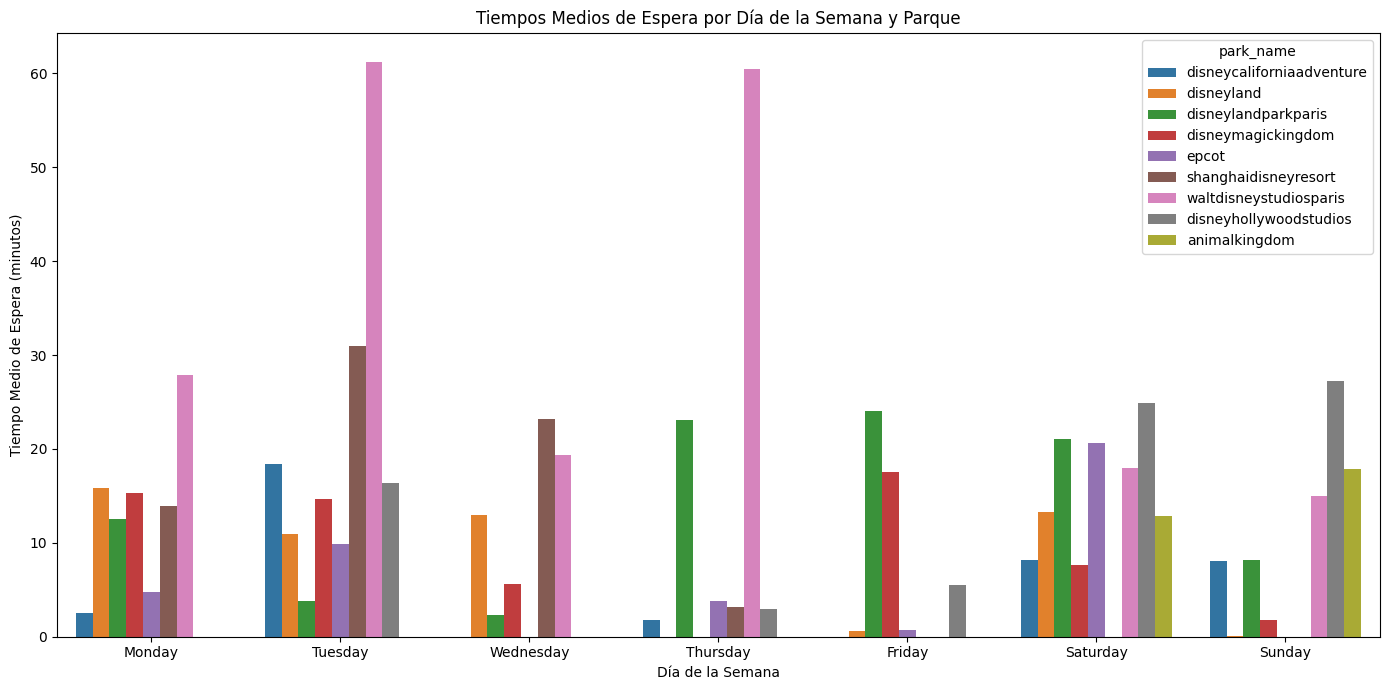

In [153]:
df_max_avg_wait_per_day_pd = df_max_avg_wait_per_day.toPandas()

df_avg_wait_per_day = df_max_avg_wait_per_day_pd.groupby(["park_name", "local_weekday"])["avg_wait_time"].mean().reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_avg_wait_per_day['local_weekday'] = pd.Categorical(df_avg_wait_per_day['local_weekday'], categories=weekday_order, ordered=True)
df_avg_wait_per_day = df_avg_wait_per_day.sort_values(by=["local_weekday", "park_name"])


plt.figure(figsize=(14, 7))
sns.barplot(x="local_weekday", y="avg_wait_time", hue="park_name", data=df_avg_wait_per_day, errorbar=None)


plt.title("Tiempos Medios de Espera por Día de la Semana y Parque")
plt.xlabel("Día de la Semana")
plt.ylabel("Tiempo Medio de Espera (minutos)")

plt.tight_layout()

plt.show()


In [ ]:
df_spark_stats_days_max = df_filtered_final.groupBy("park_name", "ride_name", "local_weekday").agg(
    max("wait_time").alias("max_wait_time")
)
df_max_wait_per_day = df_spark_stats_days_max.withColumn(
    "max_wait_day", 
    row_number().over(Window.partitionBy("park_name", "ride_name").orderBy(col("max_wait_time").desc()))
).filter(col("max_wait_day") == 1).drop("max_wait_day")

df_max_wait_per_day.orderBy("max_wait_time", ascending=False).show(truncate=False)

+-------------------------+--------------------------------------------------+-------------+-------------+
|park_name                |ride_name                                         |local_weekday|max_wait_time|
+-------------------------+--------------------------------------------------+-------------+-------------+
|disneyhollywoodstudios   |The Twilight Zone Tower of Terror™                |Sunday       |215          |
|disneylandparkparis      |Princess Pavilion                                 |Sunday       |200          |
|disneyhollywoodstudios   |Star Wars: Rise of the Resistance                 |Wednesday    |180          |
|animalkingdom            |Avatar Flight of Passage                          |Thursday     |180          |
|disneyhollywoodstudios   |Rock 'n' Roller Coaster Starring Aerosmith        |Sunday       |165          |
|shanghaidisneyresort     |Seven Dwarfs Mine Train                           |Friday       |165          |
|shanghaidisneyresort     |Soaring Ov

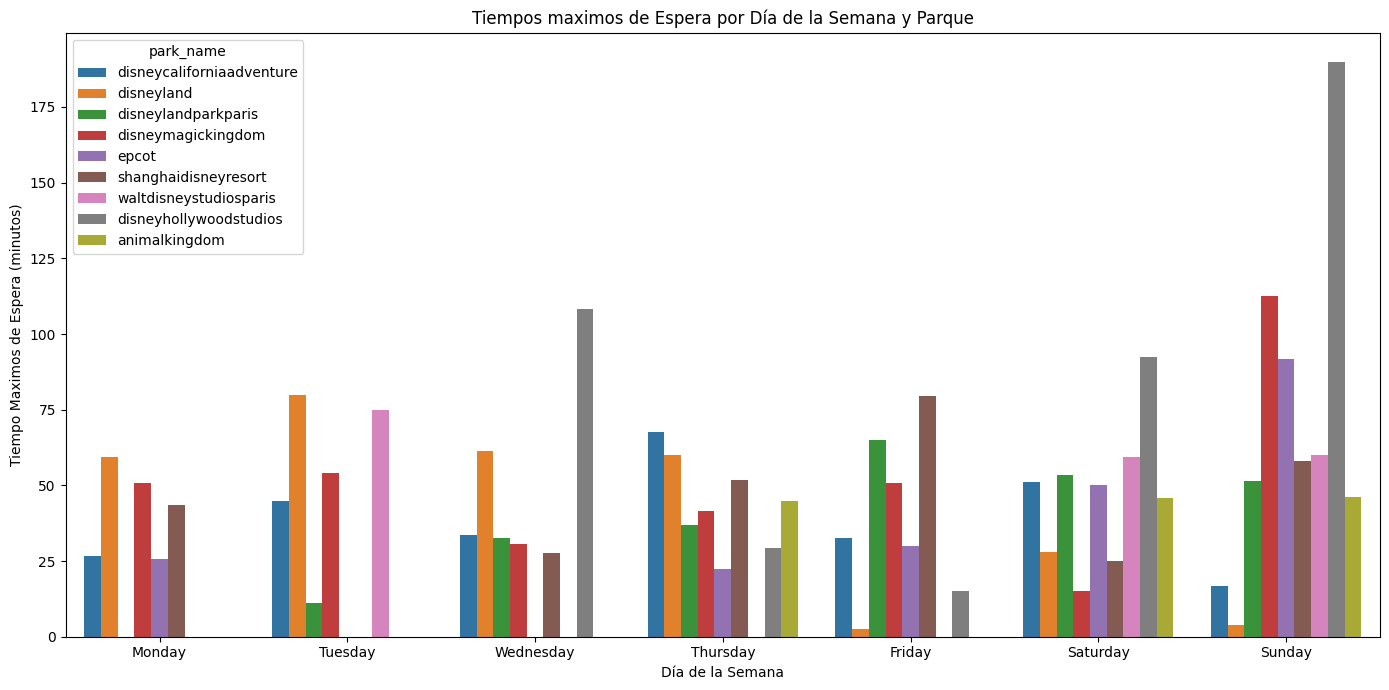

In [155]:
df_max_wait_per_day_pd = df_max_wait_per_day.toPandas()

df_max_wait_per_day = df_max_wait_per_day_pd.groupby(["park_name", "local_weekday"])["max_wait_time"].mean().reset_index()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_max_wait_per_day['local_weekday'] = pd.Categorical(df_max_wait_per_day['local_weekday'], categories=weekday_order, ordered=True)
df_max_wait_per_day = df_max_wait_per_day.sort_values(by=["local_weekday", "park_name"])


plt.figure(figsize=(14, 7))
sns.barplot(x="local_weekday", y="max_wait_time", hue="park_name", data=df_max_wait_per_day, errorbar=None)


plt.title("Tiempos maximos de Espera por Día de la Semana y Parque")
plt.xlabel("Día de la Semana")
plt.ylabel("Tiempo Maximos de Espera (minutos)")

plt.tight_layout()

plt.show()

# DIAS CON MAS TIEMPO DE ESPERA

### Tiempo medio de espera.

In [156]:
df_avg_wait_per_day = df_filtered_final.groupBy("park_name", "local_date").agg(
    avg("wait_time").alias("avg_wait_time")
)

window_spec = Window.partitionBy("park_name").orderBy(col("avg_wait_time").desc())

df_max_avg_wait_day = df_avg_wait_per_day.withColumn(
    "rank", row_number().over(window_spec)
).filter(col("rank") == 1).drop("rank")

df_max_avg_wait_day.orderBy('local_date').show(truncate=False)


+-------------------------+----------+------------------+
|park_name                |local_date|avg_wait_time     |
+-------------------------+----------+------------------+
|animalkingdom            |2025-01-25|8.988095238095237 |
|disneyland               |2025-01-27|12.713178294573643|
|epcot                    |2025-01-27|6.305555555555555 |
|disneyhollywoodstudios   |2025-01-30|12.8125           |
|disneymagickingdom       |2025-01-31|14.13125          |
|disneylandparkparis      |2025-02-01|18.12087912087912 |
|waltdisneystudiosparis   |2025-02-01|29.547511312217196|
|shanghaidisneyresort     |2025-02-05|35.166666666666664|
|disneycaliforniaadventure|2025-02-09|12.090277777777779|
+-------------------------+----------+------------------+



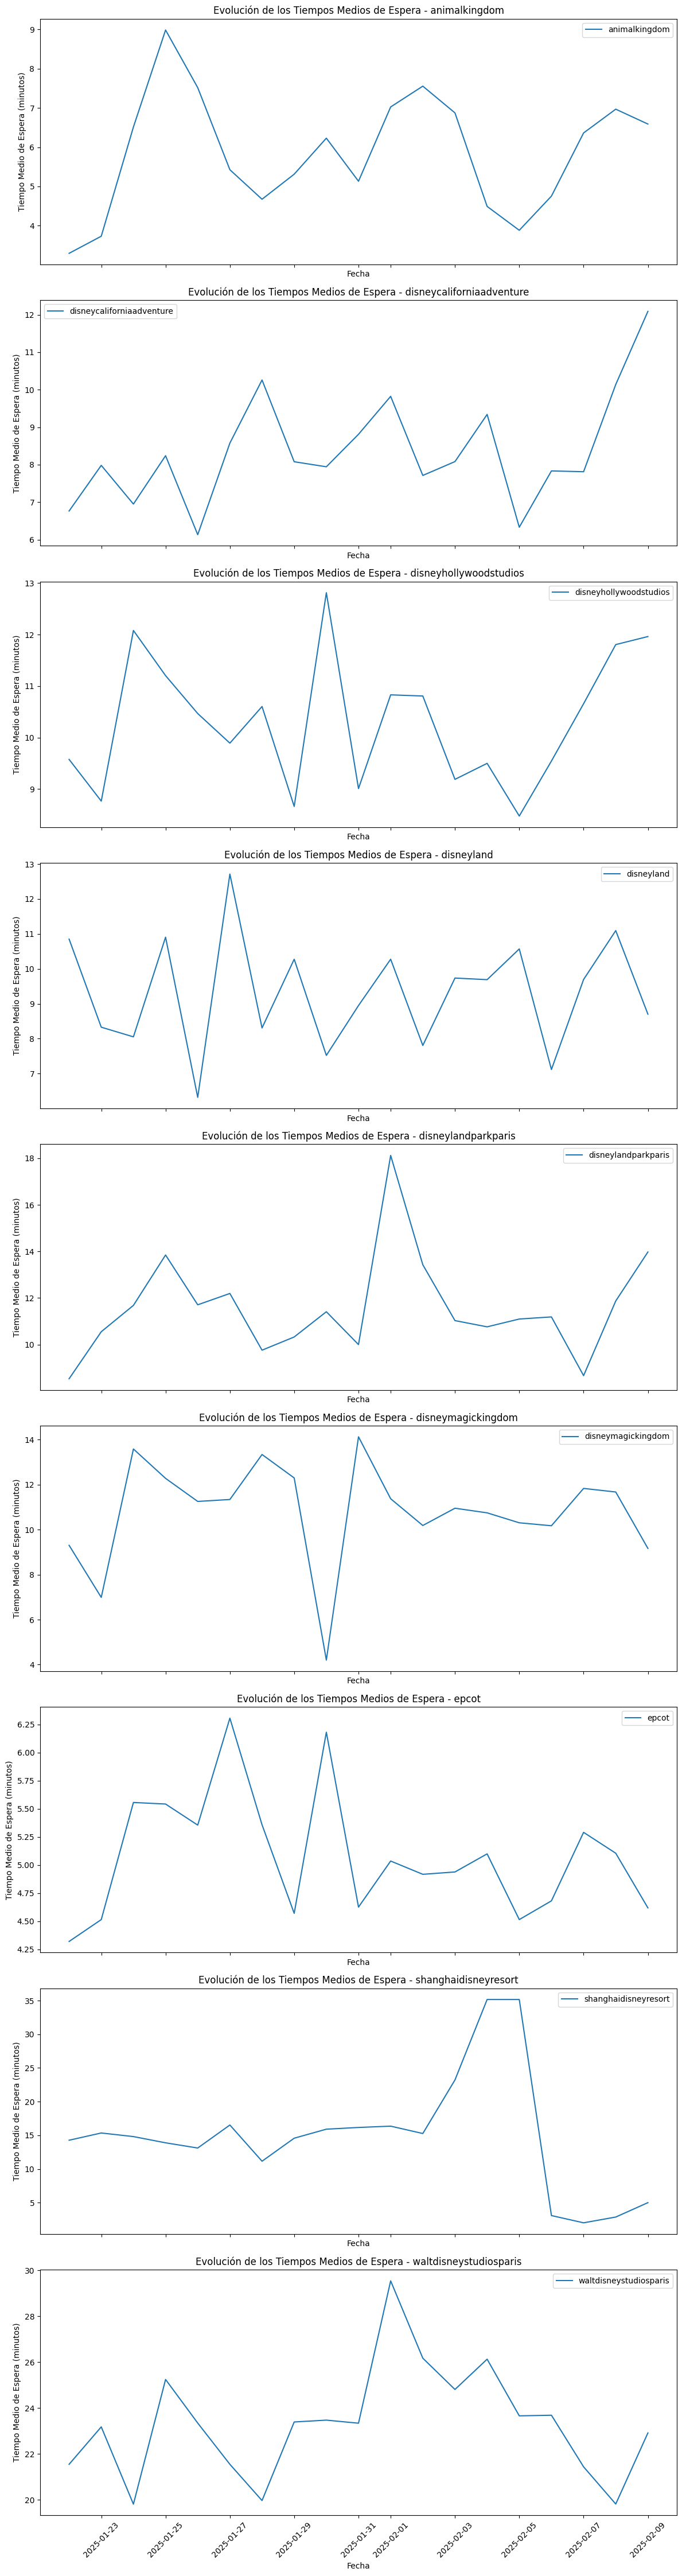

In [157]:
df_avg_wait_per_day_pd = df_avg_wait_per_day.toPandas()
# Asegurarnos de que 'local_date' esté en formato datetime
df_avg_wait_per_day_pd["local_date"] = pd.to_datetime(df_avg_wait_per_day_pd["local_date"])

# Ordenar los datos por parque y fecha
df_avg_wait_per_day_pd = df_avg_wait_per_day_pd.sort_values(by=["park_name", "local_date"])

# Crear una figura con subgráficos para cada parque
unique_parks = df_avg_wait_per_day_pd["park_name"].unique()
fig, axes = plt.subplots(len(unique_parks), 1, figsize=(12, len(unique_parks)*5), sharex=True)

# Asegurarnos de que 'axes' siempre sea una lista (en caso de un solo parque)
if len(unique_parks) == 1:
    axes = [axes]

# Iterar sobre los parques y graficar la evolución de los tiempos medios de espera
for i, park in enumerate(unique_parks):
    df_park = df_avg_wait_per_day_pd[df_avg_wait_per_day_pd["park_name"] == park]
    axes[i].plot(df_park["local_date"], df_park["avg_wait_time"], label=park)
    axes[i].set_title(f"Evolución de los Tiempos Medios de Espera - {park}")
    axes[i].set_xlabel("Fecha")
    axes[i].set_ylabel("Tiempo Medio de Espera (minutos)")
    axes[i].legend()
    axes[i].tick_params(axis="x", rotation=45)

    # Asegurarse de que las fechas sean legibles en el eje X
    axes[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

# Ajustar la presentación del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()


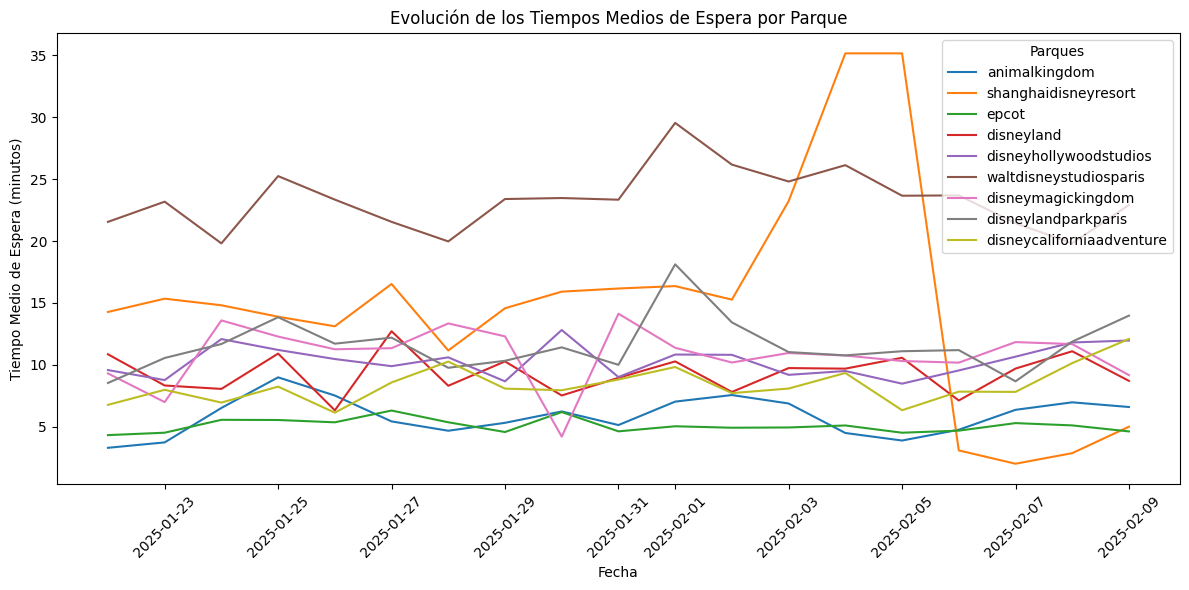

In [158]:
df_avg_wait_per_day_pd["local_date"] = pd.to_datetime(df_avg_wait_per_day_pd["local_date"])

# Ordenar los datos por fecha
df_avg_wait_per_day_pd = df_avg_wait_per_day_pd.sort_values(by=["local_date"])

# Crear una figura para el gráfico
plt.figure(figsize=(12, 6))

# Iterar sobre los parques y graficar la evolución de los tiempos medios de espera en el mismo gráfico
for park in df_avg_wait_per_day_pd["park_name"].unique():
    df_park = df_avg_wait_per_day_pd[df_avg_wait_per_day_pd["park_name"] == park]
    plt.plot(df_park["local_date"], df_park["avg_wait_time"], label=park)

# Títulos y etiquetas
plt.title("Evolución de los Tiempos Medios de Espera por Parque")
plt.xlabel("Fecha")
plt.ylabel("Tiempo Medio de Espera (minutos)")
plt.xticks(rotation=45)

# Añadir leyenda
plt.legend(title="Parques")

# Ajustar la presentación del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# POR HORAS

In [160]:

df_avg_wait_by_hour = df_filtered_final.groupBy("park_name", "local_hour").agg(
    avg("wait_time").alias("avg_wait_time")
)

window_spec = Window.partitionBy("park_name").orderBy(desc("avg_wait_time"))

df_avg_wait_by_hour = df_avg_wait_by_hour.withColumn(
    "rank", row_number().over(window_spec)
)

df_avg_wait_by_hour_result = df_avg_wait_by_hour.filter(col("rank") == 1).drop("rank")

df_avg_wait_by_hour_result.orderBy("avg_wait_time", ascending=False).show(truncate=False)


+-------------------------+----------+------------------+
|park_name                |local_hour|avg_wait_time     |
+-------------------------+----------+------------------+
|waltdisneystudiosparis   |11        |33.251633986928105|
|shanghaidisneyresort     |10        |29.797535211267604|
|disneyhollywoodstudios   |11        |23.837719298245613|
|disneymagickingdom       |12        |23.610013175230566|
|disneylandparkparis      |11        |20.22203947368421 |
|disneyland               |15        |19.945388349514563|
|disneycaliforniaadventure|15        |18.517241379310345|
|animalkingdom            |11        |15.697115384615385|
|epcot                    |10        |12.755281690140846|
+-------------------------+----------+------------------+



In [161]:
df_max_wait_by_hour = df_filtered_final.groupBy("park_name", "local_hour").agg(
    max("wait_time").alias("max_wait_time")
)

window_spec = Window.partitionBy("park_name").orderBy(desc("max_wait_time"))

df_max_wait_by_hour = df_max_wait_by_hour.withColumn(
    "rank", row_number().over(window_spec)
)

df_max_wait_by_hour_result = df_max_wait_by_hour.filter(col("rank") == 1).drop("rank")

df_max_wait_by_hour_result.orderBy("max_wait_time", ascending=False).show(truncate=False)


+-------------------------+----------+-------------+
|park_name                |local_hour|max_wait_time|
+-------------------------+----------+-------------+
|disneyhollywoodstudios   |21        |215          |
|disneylandparkparis      |10        |200          |
|animalkingdom            |10        |180          |
|shanghaidisneyresort     |10        |165          |
|disneymagickingdom       |17        |155          |
|disneycaliforniaadventure|21        |135          |
|disneyland               |13        |120          |
|epcot                    |10        |120          |
|waltdisneystudiosparis   |16        |120          |
+-------------------------+----------+-------------+



In [162]:

df_avg_wait_by_ride_hour = df_filtered_final.groupBy( "park_name", "ride_name", "local_hour").agg(
    avg("wait_time").alias("avg_wait_time")
)

window_spec = Window.partitionBy("ride_name").orderBy(desc("avg_wait_time"))

df_avg_wait_by_ride_hour = df_avg_wait_by_ride_hour.withColumn(
    "rank", row_number().over(window_spec)
)

df_avg_wait_by_ride_hour_result = df_avg_wait_by_ride_hour.filter(col("rank") == 1).drop("rank")

df_avg_wait_by_ride_hour_result.orderBy("avg_wait_time", ascending=False).show(truncate=False)


+-------------------------+--------------------------------------------------+----------+------------------+
|park_name                |ride_name                                         |local_hour|avg_wait_time     |
+-------------------------+--------------------------------------------------+----------+------------------+
|disneylandparkparis      |Princess Pavilion                                 |10        |126.47058823529412|
|shanghaidisneyresort     |Soaring Over the Horizon                          |17        |107.8125          |
|shanghaidisneyresort     |Seven Dwarfs Mine Train                           |10        |105.83333333333333|
|animalkingdom            |Avatar Flight of Passage                          |10        |100.52631578947368|
|disneymagickingdom       |TRON Lightcycle / Run                             |20        |98.15789473684211 |
|shanghaidisneyresort     |Zootopia: Hot Pursuit                             |13        |92.22222222222223 |
|waltdisneystudiosp

In [163]:

df_max_wait_by_ride_hour = df_filtered_final.groupBy("park_name", "ride_name", "local_hour").agg(
    max("wait_time").alias("max_wait_time")
)

# Crear una ventana para obtener la hora con el mayor tiempo de espera por atracción
window_spec = Window.partitionBy("ride_name").orderBy(desc("max_wait_time"))

# Añadir una columna con el ranking para obtener la hora con mayor tiempo de espera
df_max_wait_by_ride_hour = df_max_wait_by_ride_hour.withColumn(
    "rank", row_number().over(window_spec)
)

# Filtrar los registros con el rango 1 (la hora con mayor tiempo de espera para cada atracción)
df_max_wait_by_ride_hour_result = df_max_wait_by_ride_hour.filter(col("rank") == 1).drop("rank")

# Ordenar los resultados por max_wait_time de mayor a menor
df_max_wait_by_ride_hour_result.orderBy("max_wait_time", ascending = False).show(truncate=False)


+-------------------------+--------------------------------------------------+----------+-------------+
|park_name                |ride_name                                         |local_hour|max_wait_time|
+-------------------------+--------------------------------------------------+----------+-------------+
|disneyhollywoodstudios   |The Twilight Zone Tower of Terror™                |21        |215          |
|disneylandparkparis      |Princess Pavilion                                 |12        |200          |
|animalkingdom            |Avatar Flight of Passage                          |10        |180          |
|disneyhollywoodstudios   |Star Wars: Rise of the Resistance                 |11        |180          |
|shanghaidisneyresort     |Seven Dwarfs Mine Train                           |10        |165          |
|disneyhollywoodstudios   |Rock 'n' Roller Coaster Starring Aerosmith        |21        |165          |
|shanghaidisneyresort     |Soaring Over the Horizon             